In [1]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

In [2]:
df = pd.read_csv("output/annotated youtube videos/ytcomments.csv")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df["categories"]
df = df[["text","categories"]]
df.columns = ["text","categories"]
categories = list(df.columns.values)
categories

['text', 'categories']

In [4]:
#deze eruit gehaald om te testen zonder none
df = df.fillna(" none")
df = df[df.categories != " none"]

df.categories = df.categories.str.replace("[","")
df.categories = df.categories.str.replace("]","")
df.categories = df.categories.str.replace(",","")
df.categories = df.categories.str.replace("'","")
df.categories = df.categories.str.split()


In [5]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('categories')),
                          columns=mlb.classes_,
                          index=df.index))
df.drop(["7.0","4.0"],axis=1,inplace=True)

In [6]:
df_toxic = df.drop(['text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,composer,126
1,composition,321
2,experience,48
3,genre,13
4,media_host,14
5,media_host_related,2
6,original_poster,61
7,parallel_activities,13
8,performance,277
9,performer,31


Text(0.5, 0, 'category')

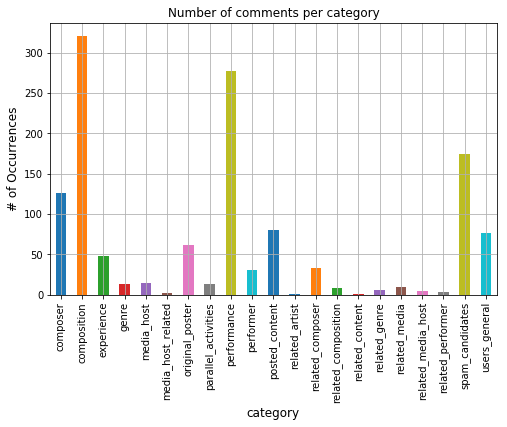

In [7]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0.5, 0, '# of categories')

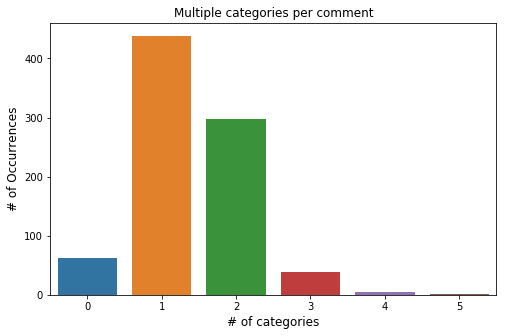

In [8]:
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('$', '', text)
    text = text.strip(' ')
    return text
df.rename(columns={"text":"comment_text"}, inplace=True)


In [10]:
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))


In [11]:
x = df.drop("comment_text", axis=1)
x.columns

Index(['composer', 'composition', 'experience', 'genre', 'media_host',
       'media_host_related', 'original_poster', 'parallel_activities',
       'performance', 'performer', 'posted_content', 'related_artist',
       'related_composer', 'related_composition', 'related_content',
       'related_genre', 'related_media', 'related_media_host',
       'related_performer', 'spam_candidates', 'users_general'],
      dtype='object')

In [12]:
categories = x.columns
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)
X_train = train.comment_text
X_test = test.comment_text
print(X_train.shape)
print(X_test.shape)

(565,)
(279,)


In [13]:
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print('Test recall is {}'.format(recall_score(test[category], prediction)))
    print('Test precision is {}'.format(recall_score(test[category], prediction)))

... Processing composer
Test accuracy is 0.8422939068100358
Test recall is 0.0
Test precision is 0.0
... Processing composition
Test accuracy is 0.6487455197132617
Test recall is 0.22935779816513763
Test precision is 0.22935779816513763
... Processing experience
Test accuracy is 0.9390681003584229
Test recall is 0.0
Test precision is 0.0
... Processing genre
Test accuracy is 0.982078853046595
Test recall is 0.0
Test precision is 0.0
... Processing media_host
Test accuracy is 0.996415770609319
Test recall is 0.0
Test precision is 0.0
... Processing media_host_related
Test accuracy is 0.996415770609319
Test recall is 0.0
Test precision is 0.0
... Processing original_poster
Test accuracy is 0.9175627240143369
Test recall is 0.0
Test precision is 0.0
... Processing parallel_activities
Test accuracy is 0.982078853046595
Test recall is 0.0
Test precision is 0.0
... Processing performance
Test accuracy is 0.7275985663082437
Test recall is 0.19540229885057472
Test precision is 0.19540229885057

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))


Test accuracy is 1.0
Test recall is 0.0
Test precision is 0.0
... Processing related_genre
Test accuracy is 0.989247311827957
Test recall is 0.0
Test precision is 0.0
... Processing related_media
Test accuracy is 0.992831541218638
Test recall is 0.0
Test precision is 0.0
... Processing related_media_host
Test accuracy is 0.996415770609319
Test recall is 0.0
Test precision is 0.0
... Processing related_performer
Test accuracy is 1.0
Test recall is 0.0
Test precision is 0.0
... Processing spam_candidates
Test accuracy is 0.8064516129032258
Test recall is 0.07017543859649122
Test precision is 0.07017543859649122
... Processing users_general
Test accuracy is 0.9175627240143369
Test recall is 0.0
Test precision is 0.0


In [14]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print('Test recall is {}'.format(recall_score(test[category], prediction)))
    print('Test precision is {}'.format(recall_score(test[category], prediction)))

... Processing composer
Test accuracy is 0.8924731182795699
Test recall is 0.4318181818181818
Test precision is 0.4318181818181818
... Processing composition
Test accuracy is 0.6774193548387096
Test recall is 0.4036697247706422
Test precision is 0.4036697247706422
... Processing experience
Test accuracy is 0.9390681003584229
Test recall is 0.058823529411764705
Test precision is 0.058823529411764705
... Processing genre
Test accuracy is 0.982078853046595
Test recall is 0.0
Test precision is 0.0
... Processing media_host
Test accuracy is 0.996415770609319
Test recall is 0.0
Test precision is 0.0
... Processing media_host_related
Test accuracy is 0.996415770609319
Test recall is 0.0
Test precision is 0.0
... Processing original_poster
Test accuracy is 0.9390681003584229
Test recall is 0.34782608695652173
Test precision is 0.34782608695652173
... Processing parallel_activities
Test accuracy is 0.982078853046595
Test recall is 0.0
Test precision is 0.0
... Processing performance
Test accura

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))


Test recall is 0.0
Test precision is 0.0
... Processing related_content
Test accuracy is 1.0
Test recall is 0.0
Test precision is 0.0
... Processing related_genre
Test accuracy is 0.989247311827957
Test recall is 0.0
Test precision is 0.0
... Processing related_media
Test accuracy is 0.992831541218638
Test recall is 0.0
Test precision is 0.0
... Processing related_media_host
Test accuracy is 0.996415770609319
Test recall is 0.0
Test precision is 0.0
... Processing related_performer
Test accuracy is 1.0
Test recall is 0.0
Test precision is 0.0
... Processing spam_candidates
Test accuracy is 0.7921146953405018
Test recall is 0.14035087719298245
Test precision is 0.14035087719298245
... Processing users_general
Test accuracy is 0.9139784946236559
Test recall is 0.043478260869565216
Test precision is 0.043478260869565216


In [15]:
SVC_pipeline.predict([X_test[1]])

KeyError: 1